### Data format

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import math
import os

%matplotlib inline

In [2]:
base_path = './DataScience2019_MRI/'

behaviour_path = 'Behavioral/cleaned'
behaviour_file = 'HBNFinalSummaries.csv'

In [3]:
behaviour_data = pd.read_csv(os.path.join(base_path, behaviour_path, behaviour_file), low_memory=False)
whole_data = behaviour_data

In [4]:
print(behaviour_data.shape)

(2096, 399)


A total of 2096 subjects are provided with a total of 399 feature columns. From those around 150 features regard the diagnosis given (15 for each of the 10 diagnosis).

We now filter out subjects that have no diagnosis given (incomplete evaluation)

In [5]:
behaviour_data = behaviour_data[behaviour_data['NoDX'].isin(['Yes', 'No'])]
behaviour_data = behaviour_data.reset_index(drop=True)

In [6]:
behaviour_data['DX_01_Cat'].value_counts()

Neurodevelopmental Disorders                                  1167
No Diagnosis Given                                             235
Anxiety Disorders                                              189
Depressive Disorders                                            94
Disruptive                                                      40
Trauma and Stressor Related Disorders                           35
Obsessive Compulsive and Related Disorders                      16
Elimination Disorders                                           11
Other Conditions That May Be a Focus of Clinical Attention       8
Bipolar and Related Disorders                                    6
Disruptive, Impulse Control and Conduct Disorders                5
Neurocognitive Disorders                                         3
Schizophrenia Spectrum and other Psychotic Disorders             3
Gender Dysphoria                                                 1
Substance Related and Addictive Disorders                     

We could also get rid of disorder categories that can be found less than a $threshold$ amount of times. We perform this taking into acount all possible diagnosis for each subject and not only the first one (DX_01_Cat).

In [7]:
threshold = 10

category_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)]

disorders_all = behaviour_data[category_columns].values.flatten()
disorders_all = disorders_all[np.array(disorders_all, dtype=np.str) != 'nan']

unique, counts = np.unique(disorders_all, return_counts=True)

most_common_disorders = []
for un, c in zip(unique, counts):
    if c >= threshold:
        most_common_disorders.append(un)
        print('{0: <60} found {1} times'.format(un, c))

Anxiety Disorders                                            found 596 times
Bipolar and Related Disorders                                found 10 times
Depressive Disorders                                         found 179 times
Disruptive                                                   found 240 times
Disruptive, Impulse Control and Conduct Disorders            found 35 times
Elimination Disorders                                        found 96 times
Feeding and Eating Disorders                                 found 10 times
Neurodevelopmental Disorders                                 found 2081 times
No Diagnosis Given                                           found 235 times
Obsessive Compulsive and Related Disorders                   found 74 times
Other Conditions That May Be a Focus of Clinical Attention   found 23 times
Schizophrenia Spectrum and other Psychotic Disorders         found 10 times
Trauma and Stressor Related Disorders                        found 77 times


In [8]:
most_common_disorders.remove('No Diagnosis Given')

We now create for each individual features concerning these diagnosis disregarding all other information about the diagnosis

In [9]:
classes = np.zeros((len(most_common_disorders), behaviour_data.shape[0]), dtype=np.int32)
df_disorders = behaviour_data[category_columns]

for i, disorder in enumerate(most_common_disorders):
    mask = df_disorders.select_dtypes(include=[object]). \
            applymap(lambda x: disorder in x if pd.notnull(x) else False)
    
    disorder_df = df_disorders[mask.any(axis=1)]
    
    np.add.at(classes[i], disorder_df.index.values, 1)

Now we can safelly remove previous diagnoses

In [10]:
behaviour_data_columns = behaviour_data.columns.values.astype(np.str)

columns_to_drop = behaviour_data_columns[
    np.flatnonzero(np.core.defchararray.find(behaviour_data_columns, 'DX')!=-1)]

behaviour_data = behaviour_data.drop(columns=columns_to_drop)

In [11]:
for disorder, classification in zip(most_common_disorders, classes):
    behaviour_data[disorder] = classification

In [12]:
behaviour_data.shape

(1814, 260)

Before removing columns with a lot of missing values we can compute some correlaction between them and some of the most common diseases.

Is this actually a good indicator? (How is EID in here?)

In [13]:
temp = most_common_disorders.copy()
temp.remove('Neurodevelopmental Disorders')

correlation = behaviour_data.drop(columns=temp) \
    .apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

In [14]:
most_correlated_features = correlation['Neurodevelopmental Disorders'] \
                            .abs().sort_values(ascending=False)[1:20].index.values
most_correlated_features

array(['Sex', 'Score_01', 'WHODAS_P_Score', 'Score_05', 'Score_04',
       'Score_03', 'Score_02', 'FTQA_Total', 'EID', 'Anonymized.ID',
       'SDS_SHY_Raw', 'SDS_Total_Raw', 'Age', 'NLES_SR_TotalOccurrence',
       'NLES_SR_Upset_Total', 'NLES_SR_TotalEvents', 'WHODAS_SR_Score',
       'AUDIT_Total_Score', 'SDS_SWTD_Raw'], dtype=object)

Now we can continue to remove columns that have a high percentage of Nan.

When considering 'data hacks' where we take into account which surveys have been completed to account for the final diagnosis this step should be more thoroughly thought.

In [15]:
threshold = 0.2

columns_mask = pd.isnull(behaviour_data).sum() / behaviour_data.shape[0] > threshold

print('Droping this many columns:', np.sum(columns_mask))

dropped_columns = behaviour_data.columns[columns_mask]

behaviour_data = behaviour_data.drop(columns=dropped_columns)

Droping this many columns: 181


In [16]:
total = 0
for feature in most_correlated_features:
    if len([s for s in dropped_columns if feature == s]) > 0:
        total += 1
        
print('{0:.2f} % of "good" features has been dropped.'.format(total / len(most_correlated_features)))

0.79 % of "good" features has been dropped.


In [17]:
behaviour_data.columns

Index(['Anonymized.ID', 'EID', 'Sex', 'Age', 'Study.Site', 'APQ_P_OPD',
       'APQ_P_Total', 'APQ_SR_OPD', 'APQ_SR_Total', 'ARI_P_Total_Score',
       'ARI_S_Total_Score', 'ASSQ_Total', 'Barratt_Total_Edu',
       'Barratt_Total_Occ', 'Barratt_Total', 'CBCL_AD', 'CBCL_WD', 'CBCL_SC',
       'CBCL_RBB', 'CBCL_AB', 'CBCL_Int', 'CBCL_Ext', 'CBCL_C', 'CBCL_Total',
       'CELF_Total', 'CTOPP_EL_R', 'CTOPP_BW_R', 'CTOPP_NR_R', 'CTOPP_RD_R',
       'CTOPP_RL_R', 'CTOPP_RSN_Comp', 'DTS_absorption', 'DTS_appraisal',
       'DTS_regulation', 'DTS_tolerance', 'DTS_total', 'EHQ_Total',
       'ICU_P_Callous', 'ICU_P_Uncaring', 'ICU_P_Unemotional', 'ICU_P_Total',
       'NLES_P_TotalEvents', 'NLES_P_Upset_Total', 'PCIAT_Total', 'mdx',
       'SCARED_P_GD', 'SCARED_P_PN', 'SCARED_P_SC', 'SCARED_P_SH',
       'SCARED_P_SP', 'SCARED_P_Total', 'SCQ_Total', 'SRS_AWR', 'SRS_COG',
       'SRS_COM', 'SRS_DSMRRB', 'SRS_MOT', 'SRS_RRB', 'SRS_SCI', 'SRS_Total',
       'WIAT_Num_Raw', 'WIAT_Pseudo_Raw', 'WIA

Statistics

An important factor is the distribution of age in the dataset, as a different age allows different questionnaires to be filled.

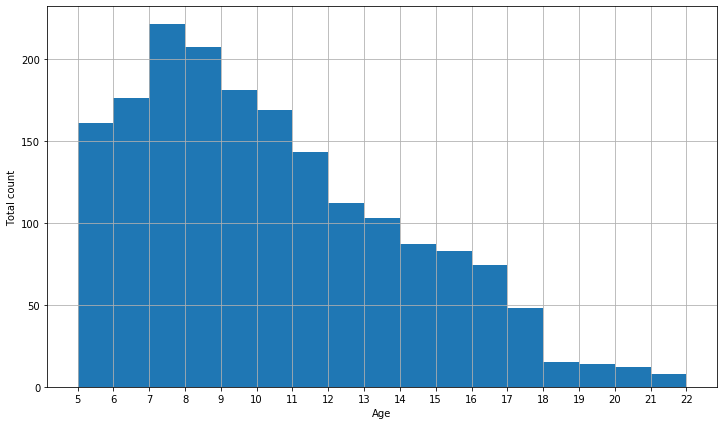

In [18]:
bins = list(range(math.floor(behaviour_data['Age'].min()), math.ceil(behaviour_data['Age'].max() + 1)))

fig = plt.gcf()
fig.set_size_inches(12, 7)
ax = behaviour_data['Age'].hist(bins = bins)
ax.set_xticks(bins)
ax.set_xlabel('Age')
ax.set_ylabel('Total count')

plt.show()

- A recommended streategy would be to use only specific ages (for instance ages 8-16)
- We could also create age bins as a new feature instead of age categories
- Age in every case plays a significant role for the interpretation of the tests and the final results

Display the largest correlation between disorders

In [19]:
correlation = behaviour_data[most_common_disorders] \
    .apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

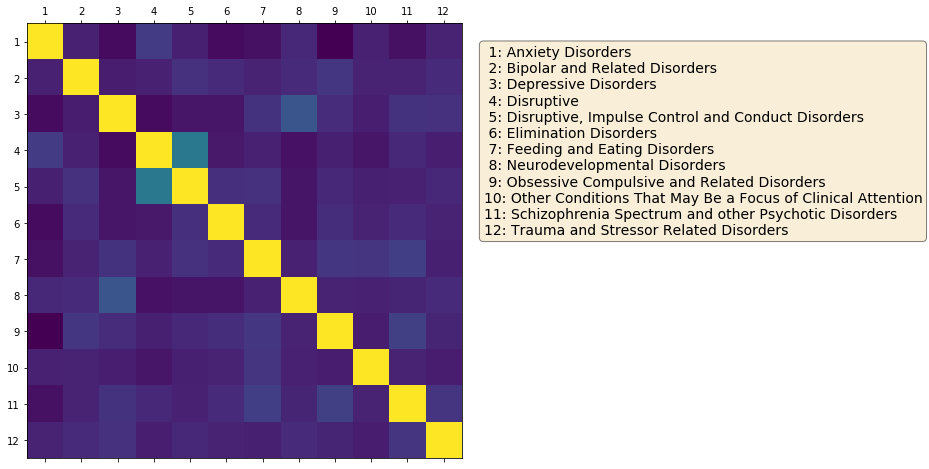

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)

ax.matshow(correlation.values)
ax.set_xticks([i for i in range(0, len(most_common_disorders))])
ax.set_yticks([i for i in range(len(most_common_disorders) - 1, -1, -1)])
ax.set_xticklabels([str(i) for i in range(1, len(most_common_disorders) + 1)])
ax.set_yticklabels([str(i) for i in range(len(most_common_disorders), 0, -1)])
ax.set_xlim([-0.5, 11.5])
ax.set_ylim([11.5, -0.5])

texts = []
for i, disorder in enumerate(most_common_disorders):
    texts.append(r'%2d: %s' % (i + 1, disorder))

textstr = '\n'.join(texts)

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(1.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()

In [21]:
display_largest = 8

# get rid of the diagonal elements and avoid displaying the same pairs twice
correlation.stack().nlargest(len(most_common_disorders) + display_largest * 2)[len(most_common_disorders)::2]

Disruptive                                  Disruptive, Impulse Control and Conduct Disorders             0.331817
Depressive Disorders                        Neurodevelopmental Disorders                                  0.179897
Obsessive Compulsive and Related Disorders  Schizophrenia Spectrum and other Psychotic Disorders          0.099270
Feeding and Eating Disorders                Schizophrenia Spectrum and other Psychotic Disorders          0.095011
Anxiety Disorders                           Disruptive                                                    0.082366
Feeding and Eating Disorders                Obsessive Compulsive and Related Disorders                    0.061134
Bipolar and Related Disorders               Obsessive Compulsive and Related Disorders                    0.061134
Feeding and Eating Disorders                Other Conditions That May Be a Focus of Clinical Attention    0.059771
dtype: float64

At the final stage we will also need to filter subjects based on those that have an MRI available!

For the above we did not consider the order of the diagnosis. A more elaborate review should also take this into account. Now we display how secondary diagnoses are distributed based on the first.

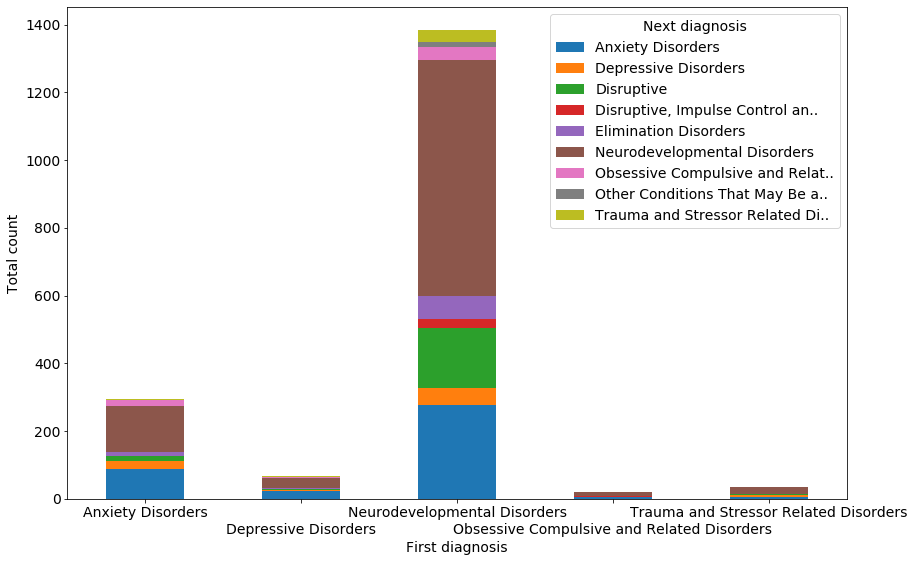

In [22]:
# most common further diagnosis based on the first diagnosis (by category)

first_categories = np.array(whole_data['DX_01_Cat'].values, dtype=np.str)

for i in range(2, 11):
    next_categories = np.array(whole_data['DX_' + str(i).zfill(2) + '_Cat'].values, dtype=np.str)

    if i == 2:
        first_categories_total = first_categories
        next_categories_total = next_categories
    else:
        first_categories_total = np.concatenate((first_categories_total, first_categories))
        next_categories_total = np.concatenate((next_categories_total, next_categories))
        
threshold = 10

# remove nans
mask = ~(first_categories_total == 'nan')
first_categories_total = first_categories_total[mask]
next_categories_total = next_categories_total[mask]

mask = ~(next_categories_total == 'nan')
first_categories_total = first_categories_total[mask]
next_categories_total = next_categories_total[mask]

# unique categories with less than threshold apearrences
unique, counts = np.unique(first_categories_total, return_counts=True)
valid_categories = unique[counts > threshold]

mask = [x in valid_categories for x in first_categories_total]
first_categories_total = first_categories_total[mask]
next_categories_total = next_categories_total[mask]

# same for secondary diagnoses
unique, counts = np.unique(next_categories_total, return_counts=True)
valid_categories = unique[counts > threshold]

mask = [x in valid_categories for x in next_categories_total]
first_categories_total = first_categories_total[mask]
next_categories_total = next_categories_total[mask]

truncate_length = 30
next_categories_total = [(data[:truncate_length] + '..') if len(data) > truncate_length
                         else data for data in next_categories_total]

rcParams['figure.figsize'] = 13, 8
rcParams['font.size'] = 14


df = pd.DataFrame({'first_diagnosis': first_categories_total, 'next_diagnosis': next_categories_total})
ct = pd.crosstab(df.first_diagnosis, df.next_diagnosis)

ax = ct.plot.bar(stacked=True)

plt.legend(title='Next diagnosis')
plt.xlabel('First diagnosis')
plt.ylabel('Total count')
plt.xticks(rotation=0)

labels = ax.set_xticklabels(np.unique(first_categories_total))
for i, label in enumerate(labels):
    label.set_y(label.get_position()[1] - (i % 2) * 0.035)

plt.tight_layout()
plt.show()

### Simple classifier

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.exceptions import UndefinedMetricWarning


for check_disorder in most_common_disorders:
    pos = most_common_disorders.index(check_disorder)

    columns_to_drop = most_common_disorders[:pos] + most_common_disorders[(pos + 1):]

    # drop 'mdx' as it may contain 'No Diagnosis'
    columns_to_drop += ['Anonymized.ID', 'EID', 'mdx']

    temp = behaviour_data.drop(columns=columns_to_drop)
    temp = temp.fillna(temp.mean())

    train, test = train_test_split(temp, test_size=0.3)

    clf = RandomForestClassifier(n_estimators=100, class_weight='balanced')

    clf.fit(train.drop(columns=[check_disorder]), train[check_disorder])

    preds = clf.predict(test.drop(columns=[check_disorder]))

    y_test = test[check_disorder]
    
    print('================================= {0} ================================='.format(check_disorder))
 
    print('accuracy', accuracy_score(y_test, preds))

    print(confusion_matrix(y_test, preds))

    print(classification_report(y_test, preds))

================================= Anxiety Disorders =================================
accuracy 0.7596330275229358
[[387  19]
 [112  27]]
              precision    recall  f1-score   support

           0       0.78      0.95      0.86       406
           1       0.59      0.19      0.29       139

    accuracy                           0.76       545
   macro avg       0.68      0.57      0.57       545
weighted avg       0.73      0.76      0.71       545

================================= Bipolar and Related Disorders =================================
accuracy 1.0
[[545]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       545

    accuracy                           1.00       545
   macro avg       1.00      1.00      1.00       545
weighted avg       1.00      1.00      1.00       545

================================= Depressive Disorders =================================
accuracy 0.8990825688073395
[[487   2]
 [ 53   3]]
    

/usr/local/lib64/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


================================= Elimination Disorders =================================
accuracy 0.9559633027522936
[[521   0]
 [ 24   0]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       521
           1       0.00      0.00      0.00        24

    accuracy                           0.96       545
   macro avg       0.48      0.50      0.49       545
weighted avg       0.91      0.96      0.93       545

================================= Feeding and Eating Disorders =================================
accuracy 0.9944954128440368
[[542   0]
 [  3   0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       542
           1       0.00      0.00      0.00         3

    accuracy                           0.99       545
   macro avg       0.50      0.50      0.50       545
weighted avg       0.99      0.99      0.99       545



/usr/local/lib64/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib64/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


================================= Neurodevelopmental Disorders =================================
accuracy 0.7651376146788991
[[ 46 114]
 [ 14 371]]
              precision    recall  f1-score   support

           0       0.77      0.29      0.42       160
           1       0.76      0.96      0.85       385

    accuracy                           0.77       545
   macro avg       0.77      0.63      0.64       545
weighted avg       0.77      0.77      0.73       545

================================= Obsessive Compulsive and Related Disorders =================================
accuracy 0.9577981651376147
[[522   0]
 [ 23   0]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       522
           1       0.00      0.00      0.00        23

    accuracy                           0.96       545
   macro avg       0.48      0.50      0.49       545
weighted avg       0.92      0.96      0.94       545

================================= Ot

/usr/local/lib64/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib64/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


================================= Schizophrenia Spectrum and other Psychotic Disorders =================================
accuracy 0.9926605504587156
[[541   0]
 [  4   0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       541
           1       0.00      0.00      0.00         4

    accuracy                           0.99       545
   macro avg       0.50      0.50      0.50       545
weighted avg       0.99      0.99      0.99       545



/usr/local/lib64/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


================================= Trauma and Stressor Related Disorders =================================
accuracy 0.9522935779816514
[[519   0]
 [ 26   0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       519
           1       0.00      0.00      0.00        26

    accuracy                           0.95       545
   macro avg       0.48      0.50      0.49       545
weighted avg       0.91      0.95      0.93       545



/usr/local/lib64/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### MRI dataset

GlobalCorticalThickness.csv
- Mean of the left and right hemisphere 
- One value per subject

CorticalThicknessLHROI.csv/CorticalThicknessRHROI.csv
- Cortical Thickness of each region according to the Destrieux Atlas
- One file per hemisphere (LH&RH) (why? For some function like language processing there is a laterization in the brain)
- Also check: https://surfer.nmr.mgh.harvard.edu/fswiki/CorticalParcellation

CorticalVolumeLHROI.csv/CorticalVolumeRHROI.csv
- Same structure as Cortical Thickness file but this time the measure is the volume brain region (extracted from lh.thickness.fsaverage)

SubCorticalVolumeLHROI.csv/SubCorticalVolumeRHROI.csv
- Volume of structures that are below the cortex, i.e. deeper inside the brain (Hippocampus, Amygdala and so on)
- Also check: https://surfer.nmr.mgh.harvard.edu/fswiki/SubcorticalSegmentation

FAPerTract.csv
- fractional anisotropy per fiber tract (20 features) calculated as average across 100 segments per fiber tract. FA is a measure used to assess the amount of myelination of fiber tracts (white matter integrity). Fiber tracts are structures that are deep inside the brain and connect specialized areas. FA is always between 0-1: 0 = isotrop: no myelination; if closer to 1 then higher anisotropy (more myelination).
- Contains also the global FA as one of the last columns (it’s the mean of all tracts). We will provide another alternative computation of that measure soon. 
- See this to get started: http://mriquestions.com/dti-tensor-imaging.html

VertexwiseCorticalThickness: 
- Structured into subfolders of the 3 study sites (SI, RU and CBIC)
- Each file is the vertexwise cortical thickness obtained from and rh.thickness.fsaverage respectively

A problem we have encountered is the amount of subjects for which all data is available

In [24]:
mri_path = 'MRI'
dti_path = 'DTI'
structural_path = 'structuralMRI'

fa_file = 'FAPerTract.csv'
global_ct_file = 'GlobalCorticalThickness.csv'

In [25]:
fa_data = pd.read_csv(os.path.join(base_path, mri_path, dti_path, fa_file))
global_ct_data = pd.read_csv(os.path.join(base_path, mri_path, structural_path, global_ct_file))

print('Number of subjects with behaviour data', whole_data.shape[0])
print('Number of subjects with FA data (DTI) ', fa_data.shape[0])
print('Number of subjects with structural MRI data', global_ct_data.shape[0])



print()
print('Number of subjects with all three data types', 
     len(list(set(whole_data['EID'].values) & set(fa_data['ID'].values) & set(global_ct_data['ID'].values))))

Number of subjects with behaviour data 2096
Number of subjects with FA data (DTI)  977
Number of subjects with structural MRI data 1385

Number of subjects with all three data types 838


We can now visualize the distribution of the FA data based on the first diagnosis

In [26]:
# merge to keep only same ids and keep track of the first diagnosis

fa_data = fa_data.fillna(fa_data.mean())

merged = pd.merge(fa_data, whole_data[['EID', 'DX_01_Cat']], how='inner', on=None, left_on='ID', right_on='EID')

In [27]:
data_columns = merged.columns[:-4]

fa_data_values = merged[data_columns]

In [28]:
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap

pca = PCA(n_components=2)
isomap = Isomap(n_components=2)

pca_transform = pca.fit_transform(fa_data_values)
isomap_transform = isomap.fit_transform(fa_data_values)

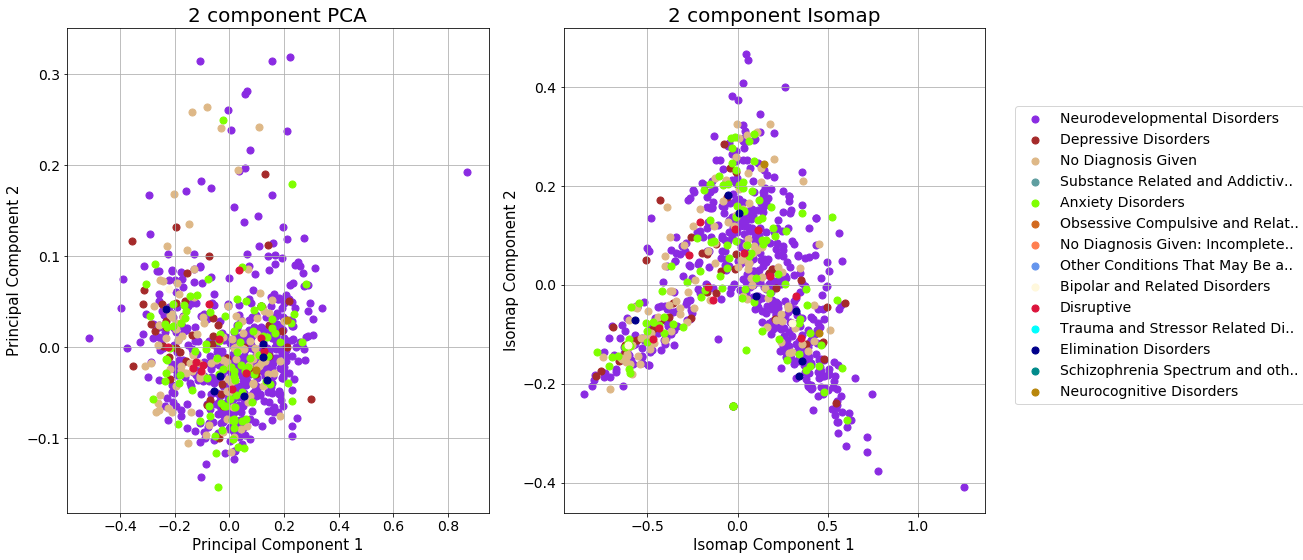

In [31]:
from matplotlib import colors as mcolors


colors = list(mcolors.cnames.values())[10:]

targets = list(merged['DX_01_Cat'].unique().astype(np.str))
targets.remove('nan')
truncate_length = 30
targets = [(data[:truncate_length] + '..') if len(data) > truncate_length else data for data in targets]

fig = plt.figure(figsize = (14,8))

ax = fig.add_subplot(1,2,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)


for target, color in zip(targets, colors):
    indicesToKeep = merged['DX_01_Cat'] == target
    ax.scatter(pca_transform[indicesToKeep][:,0], pca_transform[indicesToKeep][:,1], c=color, s=50)
    
ax.grid()

ax = fig.add_subplot(1,2,2) 
ax.set_xlabel('Isomap Component 1', fontsize = 15)
ax.set_ylabel('Isomap Component 2', fontsize = 15)
ax.set_title('2 component Isomap', fontsize = 20)

for target, color in zip(targets, colors):
    indicesToKeep = merged['DX_01_Cat'] == target
    ax.scatter(isomap_transform[indicesToKeep][:,0], isomap_transform[indicesToKeep][:,1], c=color, s=50)
    
ax.grid()

fig.legend(targets, loc='upper left', ncol=1, bbox_to_anchor=(1,0.8))
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()